(parameters_recovery)=
# Parameters recovery, prior predictive and posterior predictive sampling

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
    ! pip install pyhgf

In [2]:
from numpy import loadtxt
import numpy as np
from pyhgf.distribution import hgf_logp, HGFDistribution
from pyhgf import load_data
import jax.numpy as jnp
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

np.random.seed(123)

In this tutorial, we are going to demonstrate some forms of parameters recovery, prior predictive and posterior predictive sampling that can be a way to assess the strength of the model fitting.

## Continuous HGF
### Simulate a dataset

In [3]:
n_data = 6
dataset = []
for participant in range(n_data):
    input_data = []
    kappa_1 = 1.0
    omega_1 = -10.0
    omega_2 = -10.0
    mu_1 = 0.0
    mu_2 = 0.0
    pi_1 = 1e4
    pi_2 = 1e1
    
    # two-level hierarchical gaussian random walk
    for i in range(1000):
        
        # x2
        pi_2 = np.exp(omega_2)
        mu_2 = np.random.normal(mu_2, pi_2**.5)

        # x1
        pi_1 = np.exp(kappa_1 * mu_2 + omega_1)
        mu_1 = np.random.normal(mu_1, pi_1**.5)
        
        # input node
        u = np.random.normal(mu_1, 1e-4**.5)
        input_data.append(u)

    dataset.append(np.array(input_data))

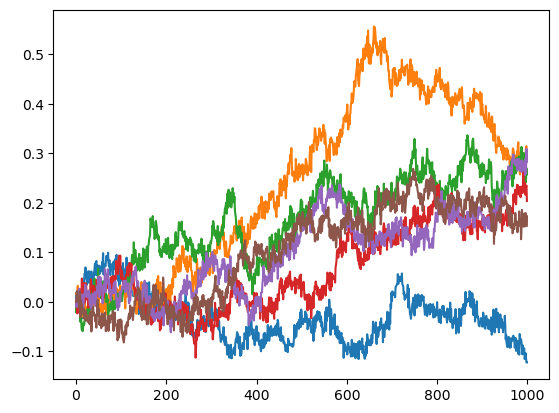

In [4]:
for rw in dataset:
    plt.plot(rw)

## Embedding a serie of HGFs in a graphical model

Here, we are goingin to estimate the parameter $omega_{1}$ from the time series created by the hierarchical random walks. All the time series were generated using $omega_{1} = -10.0$ and we want to see how the Bayesian inference can retrieve these values.

In [5]:
hgf_logp_op = HGFDistribution(
    n_levels=2,
    model_type="continuous",
    input_data=dataset,
)

In [6]:
with pm.Model() as model:
    
    # Priors
    #-------
    omega_1 = pm.Normal("omega_1", mu=0.0, sigma=2.0, shape=n_data)

    pm.Potential(
        "hgf_loglike",
        hgf_logp_op(
            omega_1=omega_1,
            omega_2=-10.0,
            continuous_precision=1e4,
            rho_1=0.0,
            rho_2=0.0,
            pi_1=1e4,
            pi_2=1e1,
            mu_1=0.0,
            mu_2=0.0,
            kappa_1=1.0,
            omega_3=jnp.nan,
            rho_3=jnp.nan,
            pi_3=jnp.nan,
            mu_3=jnp.nan,
            kappa_2=jnp.nan
        ),
    )

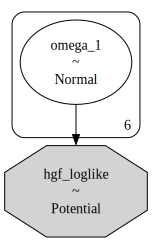

In [7]:
pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
Sequential sampling (1 chains in 1 job)
NUTS: [omega_1]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 16 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


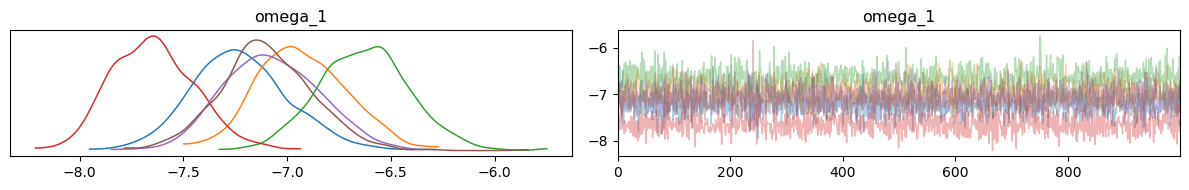

In [9]:
az.plot_trace(idata);
plt.tight_layout()

In [10]:
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
omega_1[0],-7.228,0.234,-7.630,-6.755,0.006,0.004,1695.0,673.0,NaN
omega_1[1],-6.928,0.215,-7.292,-6.497,0.006,0.004,1408.0,672.0,NaN
omega_1[2],-6.630,0.218,-7.070,-6.256,0.006,0.004,1317.0,779.0,NaN
omega_1[3],-7.645,0.201,-8.008,-7.283,0.005,0.004,1499.0,793.0,NaN
omega_1[4],-7.073,0.231,-7.472,-6.643,0.007,0.005,1274.0,714.0,NaN
omega_1[5],-7.099,0.225,-7.483,-6.639,0.005,0.004,2052.0,868.0,NaN
